In [42]:
!pip install --quiet pdfplumber PyMuPDF sentence-transformers faiss-cpu
!pip install streamlit ngrok pdfplumber matplotlib seaborn faiss-cpu sentence-transformers --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.1 MB/s eta 0:00:00


In [25]:
import pdfplumber
import numpy as np
import faiss
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sentence_transformers import SentenceTransformer
import re
import sys


Saving order_10250.pdf to order_10250.pdf
Uploaded file: order_10250.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Financial data extraction complete. Saved to 'financials.csv'.


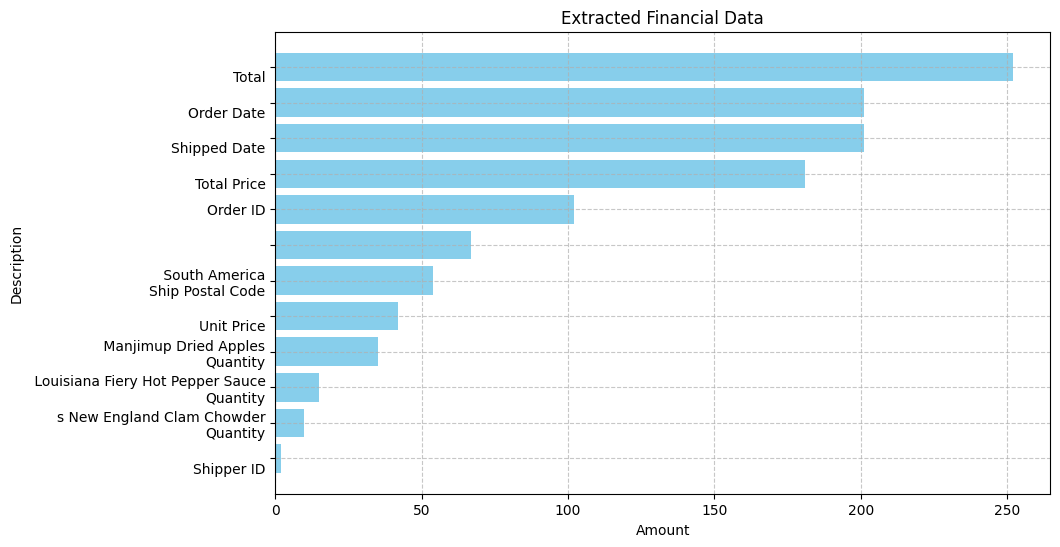

In [49]:
# Step 1: Upload the PDF
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_path}")

# Step 2: Extract Text from PDF with Error Handling
def extract_text_from_pdf(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page_num, page in enumerate(pdf.pages):
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
            if not text.strip():
                raise ValueError("No readable text found in the PDF.")
            return text
    except Exception as e:
        sys.exit(f"Error extracting text: {e}")

extracted_text = extract_text_from_pdf(pdf_path)
text_sentences = [line.strip().lower() for line in extracted_text.split("\n") if line.strip()]

# Step 3: Extract and Organize Financial Data
def extract_financials(text):
    pattern = r'([A-Za-z\s]+)\s*[:\-]?\s*(\$?\d{1,3}(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)
    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df['Amount'] = df['Amount'].replace({'\\$': '', ',': ''}, regex=True).astype(float)
    df = df.sort_values(by="Amount", ascending=False)
    return df

financial_df = extract_financials(extracted_text)

# Step 4: Save Organized Financial Data to CSV
financial_df.to_csv("financials.csv", index=False)
files.download("financials.csv")
print("Financial data extraction complete. Saved to 'financials.csv'.")

# Step 5: Create a Bar Chart of Financial Data
plt.figure(figsize=(10, 6))
plt.barh(financial_df['Description'], financial_df['Amount'], color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Description')
plt.title('Extracted Financial Data')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [21]:
# Step 6: Generate Embeddings and FAISS Index
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text_sentences)
np.save("embeddings.npy", embeddings)
with open("sentences.pkl", "wb") as f:
    pickle.dump(text_sentences, f)
files.download("embeddings.npy")
files.download("sentences.pkl")

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
faiss.write_index(index, "faiss_index.index")
files.download("faiss_index.index")
print("FAISS index created and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FAISS index created and downloaded.


In [26]:
# Load embeddings and FAISS index
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")

# Load text sentences
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

print(f"Loaded {len(text_sentences)} sentences and FAISS index with {index.ntotal} entries.")


Loaded 39 sentences and FAISS index with 39 entries.


In [28]:
# Load FAISS index and sentences (from Step 1)
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

# Load embedding model for queries
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def search_financial_query(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    results = [(text_sentences[i], distances[0][j]) for j, i in enumerate(indices[0])]
    return results

# Example Query
query = "Total revenue for Q4"
results = search_financial_query(query)

print(f"Results for query: '{query}'")
for text, distance in results:
    print(f"- {text} (Distance: {distance:.4f})")


Results for query: 'Total revenue for Q4'
- total: 174.0 (Distance: 1.1500)
- total: 168.0 (Distance: 1.1606)
- total price: (Distance: 1.1889)
- total: 98.0 (Distance: 1.1942)
- total price: 440.0 (Distance: 1.2827)


In [31]:
# Step 3: Enhanced Financial Summarization with Insights (Phase 2)
import pandas as pd
import numpy as np
import re

# Load financial data from CSV (from Phase 1 output)
financial_df = pd.read_csv("financials.csv")

# Function to generate a comprehensive financial summary with descriptions
def generate_financial_summary(df):
    total_amount = df['Amount'].sum()
    average_amount = df['Amount'].mean()
    median_amount = df['Amount'].median()
    top_expense = df.loc[df['Amount'].idxmax()]
    lowest_expense = df.loc[df['Amount'].idxmin()]

    # Key insights
    high_value_transactions = df[df['Amount'] > average_amount]
    frequent_expense_categories = df['Description'].value_counts().head(3)

    # Insight Descriptions
    summary = {
        "Total Amount": f"The total sum of all financial transactions is ${total_amount:.2f}.",
        "Average Transaction": f"The average transaction amount is ${average_amount:.2f}.",
        "Median Transaction": f"The median transaction amount, representing the midpoint of all transactions, is ${median_amount:.2f}.",
        "Highest Expense": f"The largest single expense recorded is {top_expense['Description']} totaling ${top_expense['Amount']:.2f}.",
        "Lowest Expense": f"The smallest single expense is {lowest_expense['Description']} at ${lowest_expense['Amount']:.2f}.",
        "Number of Transactions": f"A total of {len(df)} transactions were recorded.",
        "High-Value Transactions Count": f"There are {len(high_value_transactions)} transactions exceeding the average amount.",
        "Top Expense Categories": f"The most frequent expense categories are {frequent_expense_categories.to_dict()}"
    }
    return summary

# Display financial summary with key insights and descriptions
summary = generate_financial_summary(financial_df)
print("Enhanced Financial Summary with Descriptions and Key Insights:")
for key, value in summary.items():
    print(f"{key}: {value}")


Enhanced Financial Summary with Descriptions and Key Insights:
Total Amount: The total sum of all financial transactions is $1624.00.
Average Transaction: The average transaction amount is $124.92.
Median Transaction: The median transaction amount, representing the midpoint of all transactions, is $102.00.
Highest Expense: The largest single expense recorded is  Western Europe
Ship Postal Code totaling $440.00.
Lowest Expense: The smallest single expense is 
Shipper ID at $1.00.
Number of Transactions: A total of 13 transactions were recorded.
High-Value Transactions Count: There are 6 transactions exceeding the average amount.
Top Expense Categories: The most frequent expense categories are {'\nTotal': 2, '\nUnit Price': 2, ' Western Europe\nShip Postal Code': 1}


<ipython-input-32-37b842600f13>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")


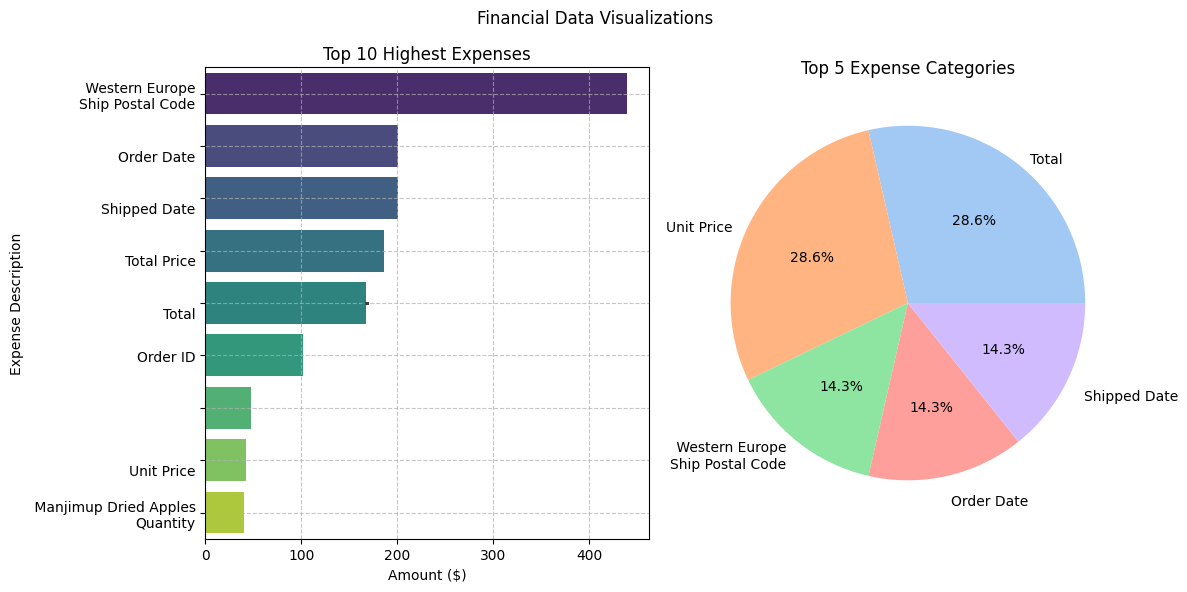

Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.


In [32]:
# Step 4: Visualization of Financial Insights (Phase 2)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load financial data from CSV
financial_df = pd.read_csv("financials.csv")

# Create visualizations from financial summary
plt.figure(figsize=(12, 6))

# Bar chart of top expenses
top_expenses = financial_df.nlargest(10, 'Amount')
plt.subplot(1, 2, 1)
sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")
plt.title('Top 10 Highest Expenses')
plt.xlabel('Amount ($)')
plt.ylabel('Expense Description')
plt.grid(True, linestyle='--', alpha=0.7)

# Pie chart of top expense categories
category_counts = financial_df['Description'].value_counts().head(5)
plt.subplot(1, 2, 2)
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 5 Expense Categories')

plt.suptitle('Financial Data Visualizations')
plt.tight_layout()
plt.show()

print("Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.")


# New Section

In [43]:
!pip install streamlit

In [57]:
from transformers import pipeline
from PIL import Image
from sentence_transformers import SentenceTransformer, util
import requests

qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


In [77]:
%%writefile app.py
import streamlit as st
import pandas as pd
import requests
import pdfplumber
import re
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# Load NLP Models
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Streamlit UI Enhancements
st.set_page_config(page_title="Smart Financial Chatbot", page_icon="💰", layout="centered")
st.title("💰 Smart Financial Analytics Chatbot")

st.markdown("### 📂 Upload Your Financial Document")
uploaded_file = st.file_uploader("Choose a file", type=["csv", "xlsx", "pdf"], label_visibility='visible')

# Function to extract text from PDF
def extract_text_from_pdf(pdf):
    text = ""
    with pdfplumber.open(pdf) as pdf_doc:
        for page in pdf_doc.pages:
            text += page.extract_text() or ""
    return text

# Function to extract financial data
def extract_financials(text):
    pattern = r'([A-Za-z\s]+)\s*[:\-]?\s*([\\$]?\d+(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)
    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df['Amount'] = df['Amount'].replace({'\\$': '', ',': ''}, regex=True).astype(float)
    return df.sort_values(by="Amount", ascending=False)

if uploaded_file:
    st.success("✅ File uploaded successfully!")
    text = extract_text_from_pdf(uploaded_file)
    financial_df = extract_financials(text)

    st.dataframe(financial_df)
    csv = financial_df.to_csv(index=False).encode('utf-8')
    st.download_button("Download CSV", csv, "financials.csv", "text/csv")

    # Enhanced Query Section with Semantic Search
    st.markdown("### 🧠 Ask Your Financial Query")
    user_query = st.text_area("Enter your query in natural language:")

    if st.button("Get Insights") and user_query:
        context = text or "No financial data available"
        embeddings = embedder.encode([user_query, context], convert_to_tensor=True)
        similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])
        result = qa_pipeline(question=user_query, context=context)

        st.write(f"**🤖 Answer:** {result['answer']}")
        st.write(f"**🔍 Similarity Score:** {similarity_score.item():.2f}")

    # Visualization Section
    graph_type = st.selectbox("Choose a Graph Type", ["Bar Chart", "Pie Chart", "Line Chart"])
    if st.button("Generate Graph"):
        plt.figure(figsize=(10, 6))
        if graph_type == "Bar Chart":
            sns.barplot(y=financial_df['Description'], x=financial_df['Amount'], palette="magma")
        elif graph_type == "Pie Chart":
            financial_df.set_index('Description')['Amount'].head(5).plot.pie(autopct='%1.1f%%', colors=sns.color_palette('magma'))
        elif graph_type == "Line Chart":
            plt.plot(financial_df['Description'], financial_df['Amount'], marker='o', color='#6A0DAD')
        plt.title(f'{graph_type} of Financial Data')
        plt.grid(True, linestyle='--', alpha=0.7)
        st.pyplot(plt)
else:
    st.info("Please upload a financial document to begin.")


Overwriting app.py


In [76]:
!pip install pyngrok --quiet
!ngrok config add-authtoken 2syfgwMFQHfHoN2eme6MELgzEuB_84ADradhJZ5jQZzBJ4Pko

import os
import signal
import subprocess
import time
from pyngrok import ngrok

# Function to kill all ngrok processes
def kill_ngrok():
    try:
        # Find and kill ngrok processes
        process = subprocess.Popen(['ps', '-aux'], stdout=subprocess.PIPE)
        output, _ = process.communicate()
        for line in output.decode('utf-8').splitlines():
            if 'ngrok' in line and 'start' not in line:  # Avoid killing the new ngrok process
                pid = int(line.split()[1])
                os.kill(pid, signal.SIGTERM)  # Terminate the process
        print("Killed all existing ngrok processes.")
    except Exception as e:
        print(f"Error killing ngrok processes: {e}")

# Start Streamlit in background
def start_streamlit():
    subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8502"])  # Changed to port 8502
    time.sleep(3)  # Give it time to start

# Launch Streamlit
start_streamlit()

# Expose URL with ngrok
ngrok.set_auth_token("2syfgwMFQHfHoN2eme6MELgzEuB_84ADradhJZ5jQZzBJ4Pko")

# Kill existing ngrok processes
kill_ngrok()
time.sleep(2)  # Give time for processes to terminate

# Disconnect all active tunnels
active_tunnels = ngrok.get_tunnels()
for tunnel in active_tunnels:
    print(f"Disconnecting tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)

# Start a new ngrok tunnel on a different port
public_url = ngrok.connect(8502)  # Changed to port 8502
print(f"Your Streamlit app is available at: {public_url}")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Killed all existing ngrok processes.


Disconnecting tunnel: https://521b-35-230-83-6.ngrok-free.app
Your Streamlit app is available at: NgrokTunnel: "https://f5f0-35-230-83-6.ngrok-free.app" -> "http://localhost:8502"


In [72]:
!ngrok close ntn_2sygB8oPGaQ956emabapLoZX9A9

ngrok - tunnel local ports to public URLs and inspect traffic

USAGE:
  ngrok [command] [flags]

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backend

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --url baz.ngrok.dev 8080                           # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --url mydomain.com                              # run ngrok with your own custom domain
  ngrok http 80 --cidr-allow 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP policy restrictions
  Upgrade your account at https://dash